##### Importing our Dependencies 

In [3]:
# from helper import *
%run "helper.ipynb"

### Objective:
Our objective with our study will be compare using risk management techniques and evaluate is importance in this specific case to portfolio construction and resource allocation

#### Collecting Stock data

* **Inital capital: 100000**

Our portfolio will be composed by these 5 stocks:

* **Edp - Portugal - Ccy : EUR - YF SYMBOL : EDP.LS**

* **Adidas - Germany - Ccy : EUR - YF SYMBOL : ADS.DE**

* **Inditex - Spain - Ccy : EUR - YF SYMBOL : IXD1.DE**

* **Just Eat Takeway - England - Ccy : EUR - YF SYMBOL : TKWY.AS**

* **LVMH -  France - Ccy : EUR - YF SYMBOL : MC.PA**

We will compare the performance of two portfolios one composed by ourselves, and another using Kelly formula. 

The performance metrics used will be sharpe ratio, max drawdown, drawdown duration, CAGR.


The focus of the below study will be the risk management of these two portfolios

In [4]:
Capital = 100000
weights = np.array([0.34,  0.14, 0.1, 0.2, 0.22])
stocks = ['EDP.LS', 'ADS.DE', 'IXD1.DE', 'TKWY.AS', 'MC.PA']
simple_returns, log_returns = get_data(stocks, start_date="2017-01-01", end_date = "2023-06-01", columns=stocks, interval = "1d")

#### Our Portfolio

Our portfolio will consist in an initial allocation of: 34% in EDP, 14% in adidas, 10% in inditex, 20% in just eat Takeway, 22% in LVMH.

Therefore our portfolio returns would consist in a linear combination of each stock return as following:

$P = 0.34S_{1} + 0.14S_{2} + 0.1S_{3}  + 0.2S_{4} + 0.22S_{5}$

where:

$P$: Portfolio returns;  $S_{1}$: EDP; $S_{2}$: Adidas; $S_{3}$: Inditex; $S_{4}$: Just Eat Takeway; $S_{5}$: LVMH

In [8]:
try:
    log_returns["our_portfolio"] = log_returns @ weights
    simple_returns["our_portfolio"] = simple_returns @ weights
except Exception:
    print("Action already performed")

Action already performed


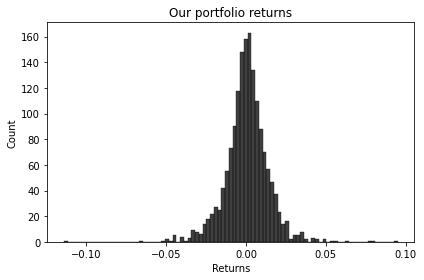

In [7]:
# Our portfolio returns histogram
sns.histplot(simple_returns.our_portfolio, fill=True, color="Black")
plt.title("Our portfolio returns")
plt.xlabel("Returns")
plt.tight_layout()
plt.show()

#### Half Kelly portfolio

* We considered, for simplicity risk free interest rate 0, and it has some logic because interest rates at that time were near 0.

The kelly & Thorp formula discovered by kelly and applied to financial markets and casino by Edward Thorp.

His (Thorp) derivation can be increadibly similar to sharpe ratio, a worldwide used metric to evaluate the performance of a specific investment, considering risk free-rate and the two first distribution moments.


Our derivation is based on the below expression and can be found in Ernest chan book (Algorithmic Trading) equation (8.2) :

* #### $F = \frac{C^{-1} M}{2}$

Where:

* $F$ : is our half kelly optimal leverage

* $C^{-1}$ : is the covariance matrix of the stocks returns

* $M$ : is the mean excess returns of these stocks




In [9]:
returns_kelly = simple_returns[stocks]
log_returns_kelly = log_returns[stocks]

In [10]:
leverages = half_kelly_Thorp(0.00, returns_kelly, stocks)

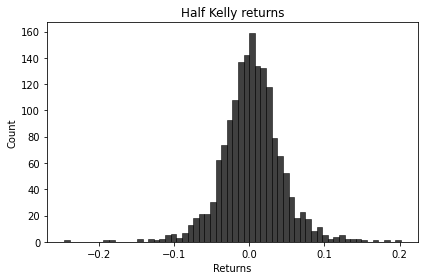

In [8]:
# Half kelly portfolio daily returns (one can see the leverage effect reflected in the x scale)
sns.histplot(returns_kelly @ leverages, fill=True, color="black")
plt.title("Half Kelly returns")
plt.xlabel("Returns")
plt.tight_layout()
plt.show()

### Quantitative risk Management

Here we will compute the portfolio losses, gains and check the VAR and ES for each portfolio at 95% and 99% confidence levels for the daily and annual periods.

But first we will check if normality holds

* Value-at-risk & Expected Shortfall

### Plots and statistical tests

#### Maximum to Sum plot
The below graphs show the MS plot of the first 4 moments of the returns distribution. 
These plots are useful to see the moments finiteness, i.e., we can see whether mean, std, skew and kurtosis are finite or not.

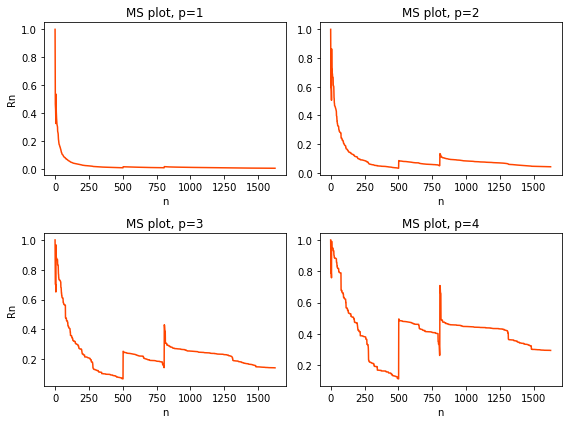

In [9]:
MSplot(simple_returns.our_portfolio)

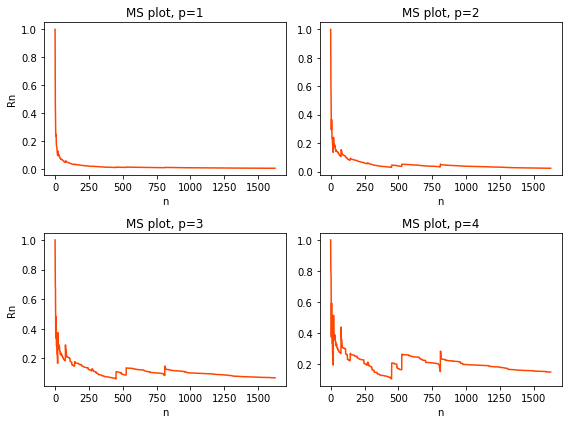

In [10]:
MSplot(returns_kelly @ leverages)

### Q-Q plot 

#### Comparing to a Normal distribition

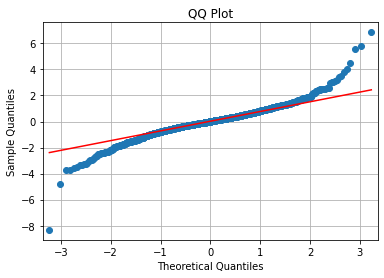

In [11]:
qqplot(data=simple_returns.our_portfolio, fit=True, dist=stats.norm, loc=0, scale=1, line="q")

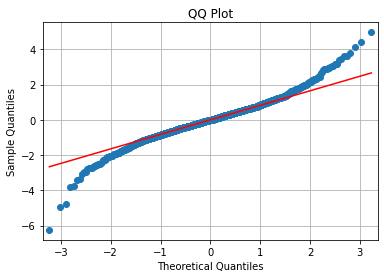

In [12]:
qqplot(data=returns_kelly @ leverages, fit=True, dist=stats.norm, loc=0, scale=1, line="q")

Visually we can assume that the underlying processes don't follow a normal distribution, 
But what can kolmogorov smirnov test tell us about normality...

Assuming a significance level of 5% or p-value of 0.05

In [13]:
if stats.ks_1samp(simple_returns.our_portfolio, stats.norm.cdf)[1] > 0.05:
    print("We not reject normality")
else:
    print("We reject normality")

We reject normality


In [14]:
if stats.ks_1samp(returns_kelly @ leverages, stats.norm.cdf)[1] > 0.05:
    print("We not reject normality")
else:
    print("We reject normality")

We reject normality


Comparison to a student T distribition, much similar than a normal distribution

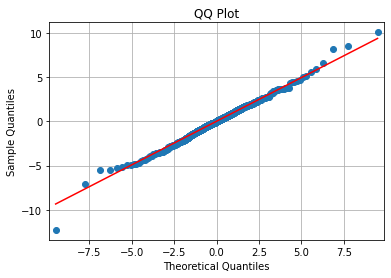

In [15]:
qqplot(data=simple_returns.our_portfolio, fit=True, dist=stats.t, line="q")

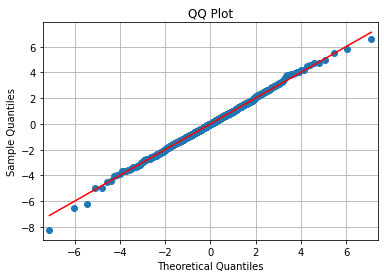

In [16]:
qqplot(data=returns_kelly @ leverages, fit=True, dist=stats.t, line="q")

#### Unparametric Approach

We use the historical returns

* VAR$_{1-\alpha} = inf\{ x: F_{X}(x) \geq 1-\alpha \}$

* ES$_{1-\alpha} = \mathbb{E}(X|X\geq$VAR$_{1-\alpha})$

##### VAR$_{0.99}$

In [17]:
present_risk_metric("daily VAR", non_parametric_VAR, p=-simple_returns.our_portfolio, q=0.99)
print("--------------------")
print(f"The daily value-at-risk of our portfolio at a confidence level of {int(0.99*100)}% is {int(Capital - (round(non_parametric_VAR(simple_returns.our_portfolio, 0.99), 4)*Capital))} euros")

The daily VAR is: 3.6309%
--------------------
The daily value-at-risk of our portfolio at a confidence level of 99% is 96490 euros


##### ES$_{0.99}$

In [18]:
present_risk_metric("daily ES", non_parametric_ES, p=-simple_returns.our_portfolio, q=0.99)
print("--------------------")
print(f"The daily expected shortfall of our portfolio at a confidence level of {int(0.99*100)}% is {int(Capital - (round(non_parametric_ES(simple_returns.our_portfolio, 0.99), 4)*Capital))} euros")

The daily ES is: 4.9137%
--------------------
The daily expected shortfall of our portfolio at a confidence level of 99% is 94830 euros


##### VAR$_{0.95}$

In [20]:
present_risk_metric("daily VAR", non_parametric_VAR, p=-simple_returns.our_portfolio, q=0.95)
print("--------------------")
print(f"The daily value-at-risk of our portfolio at a confidence level of {int(0.95*100)}% is {int(Capital - (round(non_parametric_VAR(simple_returns.our_portfolio, 0.95), 4)*Capital))} euros")

The daily VAR is: 2.1184%
--------------------
The daily value-at-risk of our portfolio at a confidence level of 95% is 97950 euros


##### ES$_{0.95}$

In [21]:
present_risk_metric("daily ES", non_parametric_ES, p=-simple_returns.our_portfolio, q=0.95)
print("--------------------")
print(f"The daily expected shortfall of our portfolio at a confidence level of {int(0.95*100)}% is {int(Capital - (round(non_parametric_ES(simple_returns.our_portfolio, 0.95), 4)*Capital))} euros")

The daily ES is: 3.1485%
--------------------
The daily expected shortfall of our portfolio at a confidence level of 95% is 96870 euros


### Parametric approach (Model building approach)
**Though we can assume that returns are not normal, we will use model building approach and assume normality to check the results**

* $cov(i, j) = \sigma_{i} \sigma_{j} \rho_{i,j}$

* $\sigma_{p}^2 = \displaystyle\sum_{i=1}^{n}\sum_{j=1}^{n} cov(i, j)\alpha_{i}\alpha_{j} $


Using matrix representation, with C being the variance-covariance matrix fof returns and $\alpha$ is the vector of portfolio's weights.

* $\sigma_{p}^2 = \alpha^T C \alpha$

**Therefore:**

* VAR$_{1-\alpha} = \mu + \sigma \times \Phi^{-1} (1-\alpha)$

* ES$_{1-\alpha} = \mu + \sigma \times \frac{\phi(\Phi^{-1} (1-\alpha))}{\alpha}$

As we are checking daily VAR and ES we could assume $\mu = $ 0, for simplicity:

* VAR$_{1-\alpha} =\sigma \times \Phi^{-1} (1-\alpha)$

* ES$_{1-\alpha} = \sigma \times \frac{\phi(\Phi^{-1} (1-\alpha))}{\alpha}$

**Our portfolio**

##### VAR$_{0.99}$

In [22]:
present_risk_metric("daily parametric VAR", parametric_var, p=simple_returns[stocks], weights=weights, alpha=0.01)
print("--------------------")
print(f"The daily parametric value-at-risk of our portfolio at a confidence level of {int(0.99*100)}% is {int(Capital - (round(parametric_var(p=simple_returns[stocks], weights=weights, alpha=0.01), 4)*Capital))} euros")

The daily parametric VAR is: 3.1997%
--------------------
The daily parametric value-at-risk of our portfolio at a confidence level of 99% is 96800 euros


##### ES$_{0.99}$

In [23]:
present_risk_metric("daily parametric ES", parametric_expected_shortfall, p=simple_returns[stocks], weights=weights, alpha=0.01)
print("--------------------")
print(f"The daily parametric expected shortfall of our portfolio at a confidence level of {int(0.99*100)}% is {int(Capital - (round(parametric_expected_shortfall(p=simple_returns[stocks], weights=weights, alpha=0.01), 4)*Capital))} euros")

The daily parametric ES is: 3.6658%
--------------------
The daily parametric expected shortfall of our portfolio at a confidence level of 99% is 96330 euros


##### VAR$_{0.95}$

In [24]:
present_risk_metric("daily parametric VAR", parametric_var, p=simple_returns[stocks], weights=weights, alpha=0.05)
print("--------------------")
print(f"The daily parametric value-at-risk of our portfolio at a confidence level of {int(0.95*100)}% is {int(Capital - (round(parametric_var(p=simple_returns[stocks], weights=weights, alpha=0.05), 4)*Capital))} euros")

The daily parametric VAR is: 2.2624%
--------------------
The daily parametric value-at-risk of our portfolio at a confidence level of 95% is 97740 euros


##### ES$_{0.95}$

In [25]:
present_risk_metric("daily parametric ES", parametric_expected_shortfall, p=simple_returns[stocks], weights=weights, alpha=0.05)
print("--------------------")
print(f"The daily parametric expected shortfall of our portfolio at a confidence level of {int(0.95*100)}% is {int(Capital - (round(parametric_expected_shortfall(p=simple_returns[stocks], weights=weights, alpha=0.05), 4)*Capital))} euros")

The daily parametric ES is: 2.8371%
--------------------
The daily parametric expected shortfall of our portfolio at a confidence level of 95% is 97160 euros


#### **Parametric method under fat tailed process** 
**Fitted parameters T-student**

The below parameters were estimated using a Maximum likelihood estimator

**Our portfolio**

In [73]:
df_fit, loc_fit, scale_fit = obtain_parameters([1, 0, 1], simple_returns.our_portfolio)

In [74]:
samples = stats.t.rvs(df_fit, loc=loc_fit, scale=scale_fit, size=len(simple_returns))

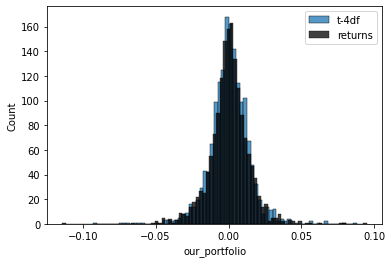

In [75]:
sns.histplot(samples, fill=True)
sns.histplot(simple_returns.our_portfolio, color="black", fill=True)
plt.legend([f"t-{round(df_fit)}df", 'returns'])
plt.show()

##### VAR$_{0.99}$

In [29]:
present_risk_metric("daily parametric (T-student) VAR", non_parametric_VAR, p=-pd.Series(samples), q=0.99)
print("--------------------")
print(f"The daily parametric (T-student) value-at-risk of our portfolio at a confidence level of {int(0.99*100)}% is {int(Capital - (round(non_parametric_VAR(-pd.Series(samples), 0.99), 4)*Capital))} euros")

The daily parametric (T-student) VAR is: 3.7635%
--------------------
The daily parametric (T-student) value-at-risk of our portfolio at a confidence level of 99% is 96240 euros


##### ES$_{0.99}$

In [30]:
present_risk_metric("daily parametric (T-student) ES", non_parametric_ES, p=-pd.Series(samples), q=0.99)
print("--------------------")
print(f"The daily parametric (T-student) expected shortfal of our portfolio at a confidence level of {int(0.99*100)}% is {int(Capital - (round(non_parametric_ES(-pd.Series(samples), 0.99), 4)*Capital))} euros")

The daily parametric (T-student) ES is: 5.6836%
--------------------
The daily parametric (T-student) expected shortfal of our portfolio at a confidence level of 99% is 94320 euros


##### VAR$_{0.95}$

In [31]:
present_risk_metric("daily parametric (T-student) VAR", non_parametric_VAR, p=-pd.Series(samples), q=0.95)
print("--------------------")
print(f"The daily parametric (T-student) value-at-risk of our portfolio at a confidence level of {int(0.95*100)}% is {int(Capital - (round(non_parametric_VAR(-pd.Series(samples), 0.95), 4)*Capital))} euros")

The daily parametric (T-student) VAR is: 2.0137%
--------------------
The daily parametric (T-student) value-at-risk of our portfolio at a confidence level of 95% is 97990 euros


##### ES$_{0.95}$

In [32]:
present_risk_metric("daily parametric (T-student) ES", non_parametric_ES, p=-pd.Series(samples), q=0.95)
print("--------------------")
print(f"The daily parametric (T-student) expected shortfal of our portfolio at a confidence level of {int(0.95*100)}% is {int(Capital - (round(non_parametric_ES(-pd.Series(samples), 0.95), 4)*Capital))} euros")

The daily parametric (T-student) ES is: 3.2262%
--------------------
The daily parametric (T-student) expected shortfal of our portfolio at a confidence level of 95% is 96770 euros


**Half kelly portfolio**

In [33]:
df_fit_, loc_fit_, scale_fit_ = obtain_parameters([1, 0, 1], returns_kelly @ leverages)

In [34]:
samples_ = stats.t.rvs(df_fit_, loc=loc_fit_, scale=scale_fit_, size=len(simple_returns))

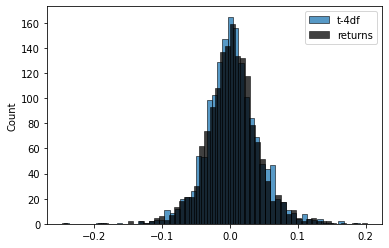

In [71]:
sns.histplot(samples_, fill=True)
sns.histplot(returns_kelly @ leverages, color="black", fill=True)
plt.legend([f"t-{round(df_fit)}df", 'returns'])
plt.show()

##### VAR$_{0.99}$

In [36]:
present_risk_metric("daily parametric (T-student) VAR", non_parametric_VAR, p=-pd.Series(samples), q=0.99)
print("--------------------")
print(f"The daily parametric (T-student) value-at-risk of our portfolio at a confidence level of {int(0.99*100)}% is {int(Capital - (round(non_parametric_VAR(-pd.Series(samples), 0.99), 4)*Capital))} euros")

The daily parametric (T-student) VAR is: 3.7635%
--------------------
The daily parametric (T-student) value-at-risk of our portfolio at a confidence level of 99% is 96240 euros


##### ES$_{0.99}$

In [37]:
present_risk_metric("daily parametric (T-student) ES", non_parametric_ES, p=-pd.Series(samples), q=0.99)
print("--------------------")
print(f"The daily parametric (T-student) expected shortfal of our portfolio at a confidence level of {int(0.99*100)}% is {int(Capital - (round(non_parametric_ES(-pd.Series(samples), 0.99), 4)*Capital))} euros")

The daily parametric (T-student) ES is: 5.6836%
--------------------
The daily parametric (T-student) expected shortfal of our portfolio at a confidence level of 99% is 94320 euros


##### VAR$_{0.95}$

In [38]:
present_risk_metric("daily parametric (T-student) VAR", non_parametric_VAR, p=-pd.Series(samples), q=0.95)
print("--------------------")
print(f"The daily parametric (T-student) value-at-risk of our portfolio at a confidence level of {int(0.95*100)}% is {int(Capital - (round(non_parametric_VAR(-pd.Series(samples), 0.95), 4)*Capital))} euros")

The daily parametric (T-student) VAR is: 2.0137%
--------------------
The daily parametric (T-student) value-at-risk of our portfolio at a confidence level of 95% is 97990 euros


##### ES$_{0.95}$

In [39]:
present_risk_metric("daily parametric (T-student) ES", non_parametric_ES, p=-pd.Series(samples), q=0.95)
print("--------------------")
print(f"The daily parametric (T-student) expected shortfal of our portfolio at a confidence level of {int(0.95*100)}% is {int(Capital - (round(non_parametric_ES(-pd.Series(samples), 0.95), 4)*Capital))} euros")

The daily parametric (T-student) ES is: 3.2262%
--------------------
The daily parametric (T-student) expected shortfal of our portfolio at a confidence level of 95% is 96770 euros


#### Aggregated risk measures 

**Our portfolio** 

In [40]:
# unparametric approach
data = rounder(list(map(non_parametric_VAR, [-simple_returns.our_portfolio, -simple_returns.our_portfolio], [0.95, 0.99])), 4)
data_ = rounder(list(map(non_parametric_ES, [-simple_returns.our_portfolio, -simple_returns.our_portfolio], [0.95, 0.99])), 4)
data = np.array([data, data_]).reshape((1, 4))

pd.DataFrame(data=data, columns=["Historical VAR 95%", "Historical VAR 99%", "Historical ES 95%", "Historical ES 99%"])

,Historical VAR 95%,Historical VAR 99%,Historical ES 95%,Historical ES 99%
0,2.1184%,3.6309%,3.1485%,4.9137%


In [41]:
#parametric approach our portfolio
data = rounder(list(map(parametric_var, [simple_returns[stocks], simple_returns[stocks]], [weights, weights], [0.05, 0.01])), 4)
data_ = rounder(list(map(parametric_expected_shortfall, [simple_returns[stocks], simple_returns[stocks]], [weights, weights], [0.05, 0.01])), 4)
data_t = rounder(list(map(non_parametric_VAR, [-pd.Series(samples), -pd.Series(samples)], [0.95, 0.99])), 4)
data_t_ = rounder(list(map(non_parametric_ES, [-pd.Series(samples), -pd.Series(samples)], [0.95, 0.99])), 4)

data_par = np.array([data, data_, data_t, data_t_]).reshape((1, 8))

pd.DataFrame(data=data_par, columns=["Normal VAR 95%", "Normal VAR 99%", "Normal ES 95%", "Normal ES 99%", "Stu. T VAR 95%", "Stu. T VAR 99%", "Stu. T ES 95%", "Stu. T ES 99%"])

,Normal VAR 95%,Normal VAR 99%,Normal ES 95%,Normal ES 99%,Stu. T VAR 95%,Stu. T VAR 99%,Stu. T ES 95%,Stu. T ES 99%
0,2.2624%,3.1997%,2.8371%,3.6658%,2.0137%,3.7635%,3.2262%,5.6836%


**Half Kelly portfolio**

In [42]:
# unparametric approach
data = rounder(list(map(non_parametric_VAR, [-returns_kelly @ leverages, -returns_kelly @ leverages], [0.95, 0.99])), 4)
data_ = rounder(list(map(non_parametric_ES, [-returns_kelly @ leverages, -returns_kelly @ leverages], [0.95, 0.99])), 4)
data = np.array([data, data_]).reshape((1, 4))

pd.DataFrame(data=data, columns=["Historical VAR 95%", "Historical VAR 99%", "Historical ES 95%", "Historical ES 99%"])

,Historical VAR 95%,Historical VAR 99%,Historical ES 95%,Historical ES 99%
0,5.9868%,10.0012%,8.6637%,13.3589%


In [43]:
#parametric approach half kelly portfolio
data = rounder(list(map(parametric_var, [simple_returns[stocks], simple_returns[stocks]], [leverages, leverages], [0.05, 0.01])), 4)
data_ = rounder(list(map(parametric_expected_shortfall, [simple_returns[stocks], simple_returns[stocks]], [leverages, leverages], [0.05, 0.01])), 4)
data_t = rounder(list(map(non_parametric_VAR, [-pd.Series(samples_), -pd.Series(samples_)], [0.95, 0.99])), 4)
data_t_ = rounder(list(map(non_parametric_ES, [-pd.Series(samples_), -pd.Series(samples_)], [0.95, 0.99])), 4)

data_par = np.array([data, data_, data_t, data_t_]).reshape((1, 8))

pd.DataFrame(data=data_par, columns=["Normal VAR 95%", "Normal VAR 99%", "Normal ES 95%", "Normal ES 99%", "Stu. T VAR 95%", "Stu. T VAR 99%", "Stu. T ES 95%", "Stu. T ES 99%"])

,Normal VAR 95%,Normal VAR 99%,Normal ES 95%,Normal ES 99%,Stu. T VAR 95%,Stu. T VAR 99%,Stu. T ES 95%,Stu. T ES 99%
0,6.5652%,9.2854%,8.2331%,10.6379%,6.1666%,11.2097%,9.0419%,13.815%


#### EVT 

##### Our portfolio 

               return value  lower ci  upper ci
return period                                  
1.0                0.041125  0.034823  0.047844
5.0                0.056559  0.047212  0.066360
10.0               0.063107  0.052459  0.074214


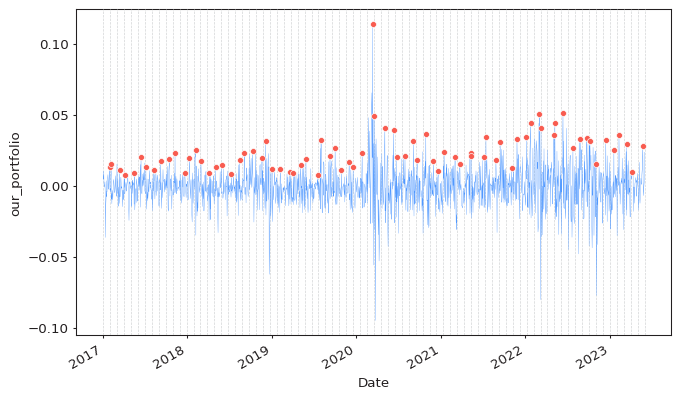

In [21]:
model = pyextremes.EVA(-simple_returns.our_portfolio)
model.get_extremes(method="BM", block_size="30D")
model.plot_extremes()
plt.savefig("block maxima", dpi=200)
model.fit_model()
summary = model.get_summary(
    return_period=[1,5,10],
    alpha=0.95,
    n_samples=1000)
print(summary)

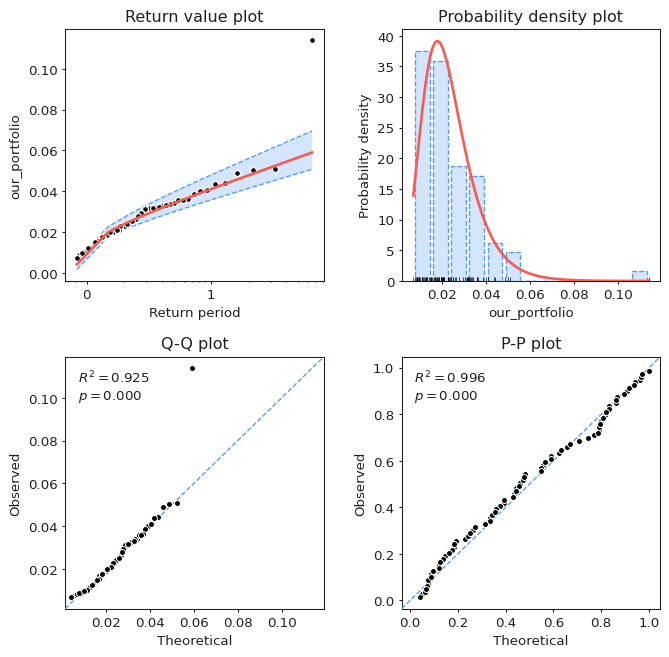

In [20]:
model.plot_diagnostic(alpha=0.95)
plt.savefig("tail estimation", dpi=200)

##### Half Kelly portfolio

               return value  lower ci  upper ci
return period                                  
1.0                0.117871  0.103153  0.134141
5.0                0.160309  0.137995  0.184323
10.0               0.178312  0.153126  0.205188


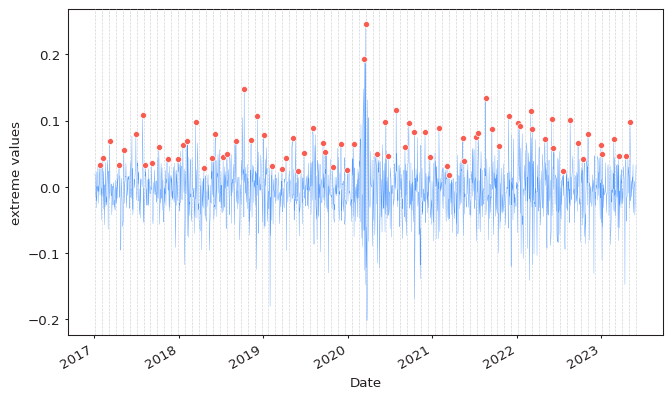

In [22]:
model = pyextremes.EVA(-(returns_kelly @ leverages))
model.get_extremes(method="BM", block_size="30D")
model.plot_extremes()
plt.savefig("block maxima", dpi=200)
model.fit_model()
summary = model.get_summary(
    return_period=[1,5,10],
    alpha=0.95,
    n_samples=1000)
print(summary)

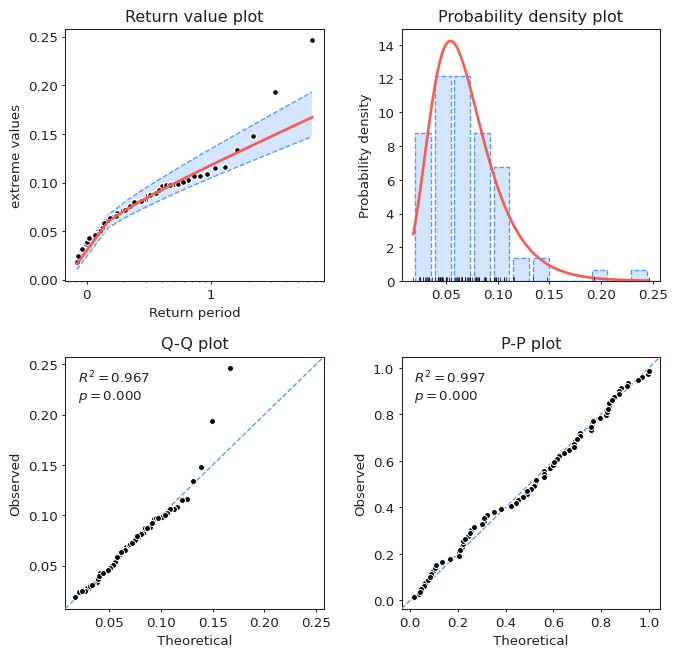

In [23]:
model.plot_diagnostic(alpha=0.95)
plt.savefig("tail estimation", dpi=200)

#### Time Series 

##### ACF & PACF

our portfolio (without leverage effect)

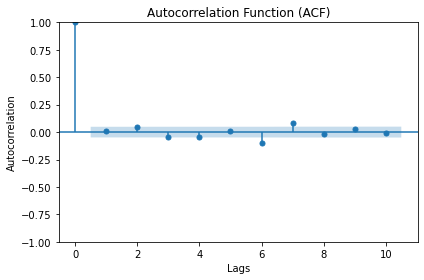

In [ ]:
ACF(x=simple_returns.our_portfolio, lags=10)

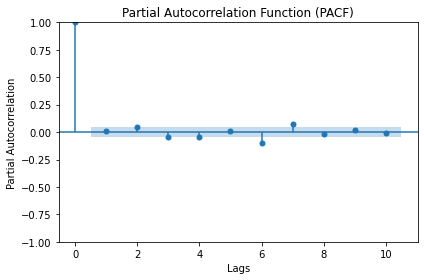

In [ ]:
PACF(x=simple_returns.our_portfolio, lags=10, method="ywm")

Half kelly portfolio

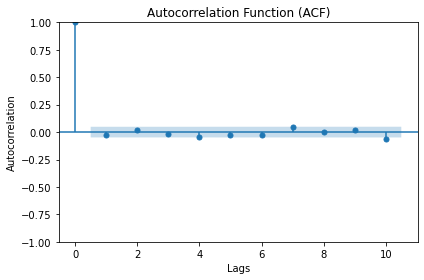

In [52]:
ACF(x=returns_kelly @ leverages, lags=10)

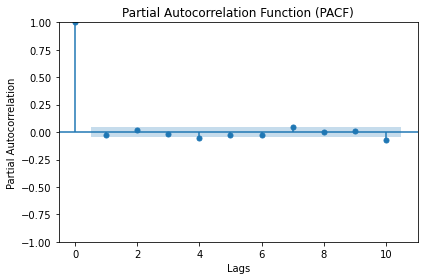

In [51]:
PACF(x=returns_kelly @ leverages, lags=10, method="ywm")

#### ACF and PCAF in absolute returns

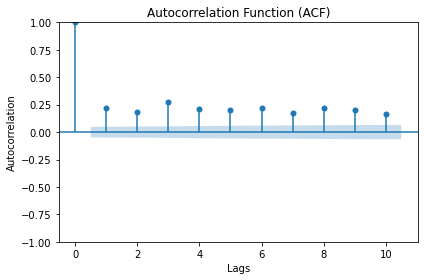

In [32]:
ACF(x=simple_returns.our_portfolio.abs(), lags=10)

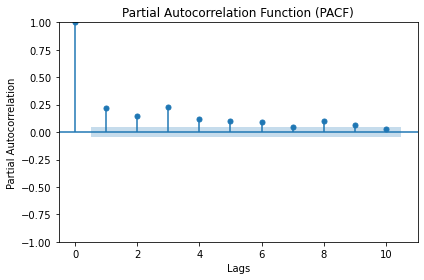

In [33]:
PACF(x=simple_returns.our_portfolio.abs(), lags=10, method="ywm")

Half kelly portfolio

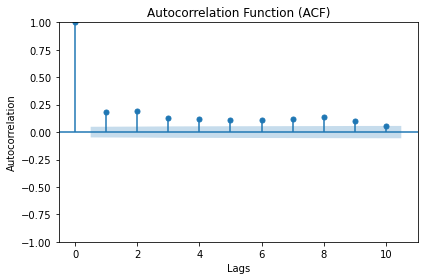

In [35]:
ACF(x=(returns_kelly @ leverages).abs(), lags=10)

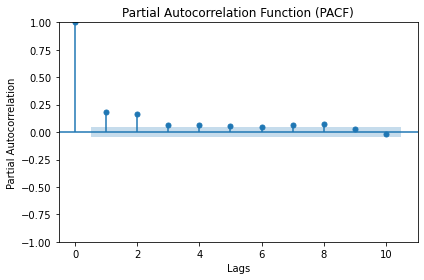

In [36]:
PACF(x=(returns_kelly @ leverages).abs(), lags=10, method="ywm")

#### Performance metrics 

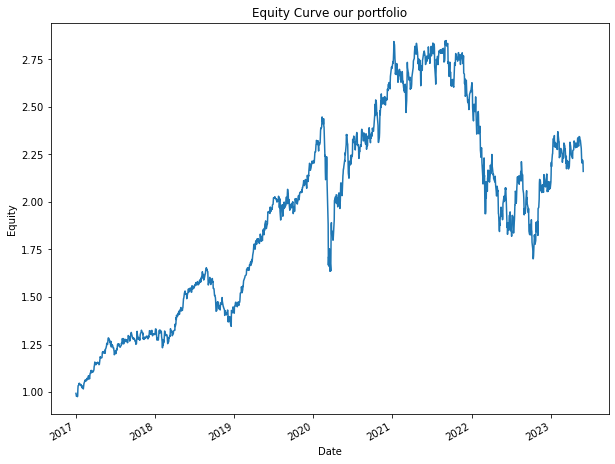

In [26]:
(simple_returns.our_portfolio + 1).cumprod().plot(figsize=(10, 8))
plt.title("Equity Curve our portfolio")
plt.ylabel("Equity")
plt.savefig("Equity curve our port", dpi=200)
plt.show()

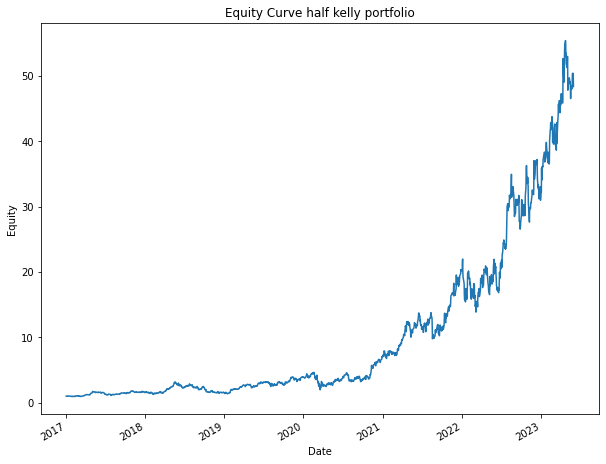

In [27]:
((returns_kelly @ leverages + 1).cumprod()).plot(figsize=(10, 8))
plt.title("Equity Curve half kelly portfolio")
plt.ylabel("Equity")
plt.savefig("Equity curve half kelly port", dpi=200)
plt.show()

#### Maximum Drawdown, drawdown duration, date of max drawdown

In [154]:
Max_drawdown, Max_drawdown_duration, index = calculateMaxDD((simple_returns.our_portfolio + 1).cumprod())
print(f"The maximum drawdown of our portfolio was {Max_drawdown*100}% and it occurred in {str(simple_returns.our_portfolio.index[index])[:10]} the duration of the drawdown was {Max_drawdown_duration} days")

The maximum drawdown of our portfolio was -30.0% and it occurred in 2022-10-12 the duration of the drawdown was 442 days


In [153]:
Max_drawdown_, Max_drawdown_duration_, index_ = calculateMaxDD((returns_kelly @ leverages + 1).cumprod())
print(f"The maximum drawdown of the kelly portfolio was at {Max_drawdown_*100}% and it occurred in {str(simple_returns.our_portfolio.index[index_])[:10]} the duration of the drawdown was {Max_drawdown_duration_} days")

The maximum drawdown of the kelly portfolio was at -48.0% and it occurred in 2020-03-19 the duration of the drawdown was 288 days


#### Sharpe Ratio 

In [168]:
print(f"The sharpe ratio of our portfolio is {sharpe(0.02, simple_returns.our_portfolio)}")

The sharpe ratio of our portfolio is 0.04


In [170]:
print(f"The sharpe ratio of the half kelly portfolio is {sharpe(0.02, returns_kelly @ leverages)}")

The sharpe ratio of the half kelly portfolio is 0.08


#### Compound annual growth rate (CAGR) 

In [28]:
i_v = ((simple_returns.our_portfolio + 1).cumprod()).iloc[0]
f_v = ((simple_returns.our_portfolio + 1).cumprod()).iloc[-1]
print(f"The CAGR ratio of our portfolio is {cagr(f_v,i_v, len(simple_returns)/365)}%")

The CAGR ratio of our portfolio is 19.07%


In [29]:
i_v = ((returns_kelly @ leverages + 1).cumprod()).iloc[0]
f_v = ((returns_kelly @ leverages + 1).cumprod()).iloc[-1]
print(f"The CAGR ratio of our portfolio is {cagr(f_v,i_v, len(simple_returns)/365)}%")

The CAGR ratio of our portfolio is 139.96%


### Appendix 

**Gains and Losses** 

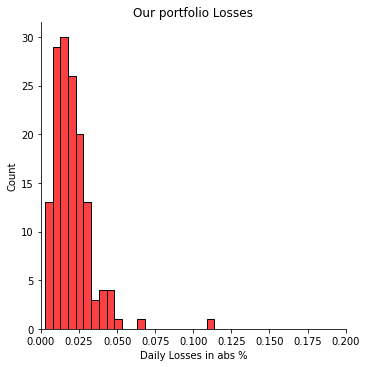

In [8]:
sns.displot(losses(simple_returns).our_portfolio, color="red")
plt.xlim([0, 0.2])
plt.title("Our portfolio Losses")
plt.xlabel("Daily Losses in abs %")
plt.show()

##### Our portfolio Gains 

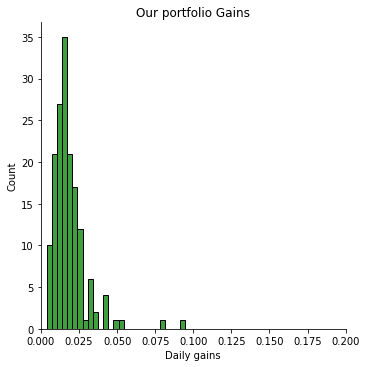

In [9]:
sns.displot(gains(simple_returns).our_portfolio, color="Green")
plt.xlim([0, 0.2])
plt.title("Our portfolio Gains")
plt.xlabel("Daily gains")
plt.show()

##### Half Kelly portfolio Losses

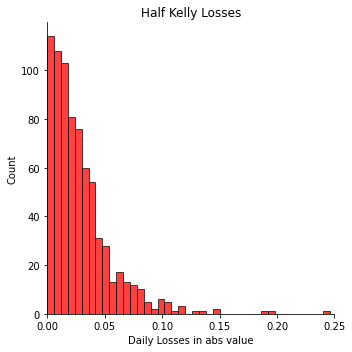

In [10]:
sns.displot(losses(returns_kelly @ leverages), color="red")
plt.xlim([0, 0.25])
plt.title("Half Kelly Losses")
plt.xlabel("Daily Losses in abs value")
plt.tight_layout()
plt.show()

##### Half Kelly portfolio Gains

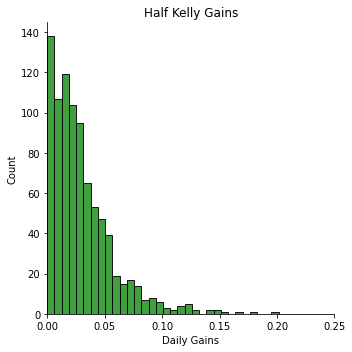

In [11]:
sns.displot(gains(returns_kelly @ leverages), color="green")
plt.xlim([0, 0.25])
plt.title("Half Kelly Gains")
plt.xlabel("Daily Gains")
plt.tight_layout()
plt.show()

#### Correlation matrix

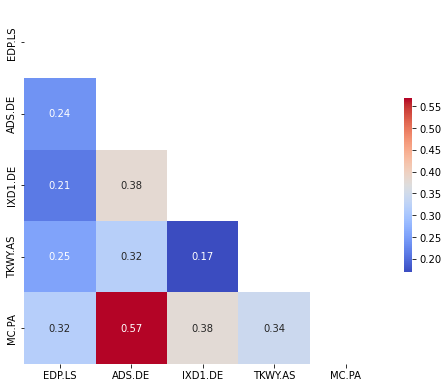

In [16]:
correlation_matrix(simple_returns, stocks)

#### Sequential returns 

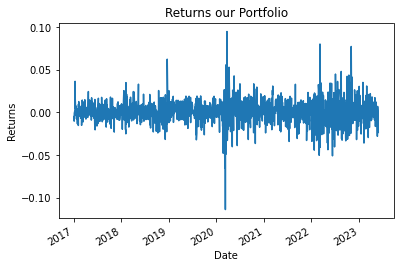

In [29]:
simple_returns.our_portfolio.plot()
plt.title("Returns our Portfolio")
plt.ylabel("Returns")
plt.savefig("our portfolio sequential returns", dpi=200)
plt.show()

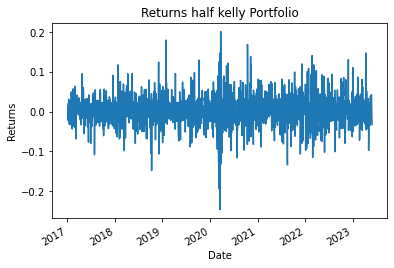

In [30]:
(returns_kelly @ leverages).plot()
plt.title("Returns half kelly Portfolio")
plt.ylabel("Returns")
plt.savefig("half kelly sequential returns", dpi=200)
plt.show()